# Detecting Quantum Dots

This notebook provides you with a complete code example that trains a U-Net to determine the positions of quantum dots in experimental images acquired with a fluorescence microscope.

## Loading Fluorescence Images of Quantum Dots

Load an image of quantum dot acquired with a fluorescence microscope (from a video of quantum dots labeling a membrane proteins in the membrane of living cells) ...

In [3]:
from PIL import Image

image_of_particles = Image.open("frame_0.tif")

... plot it ...

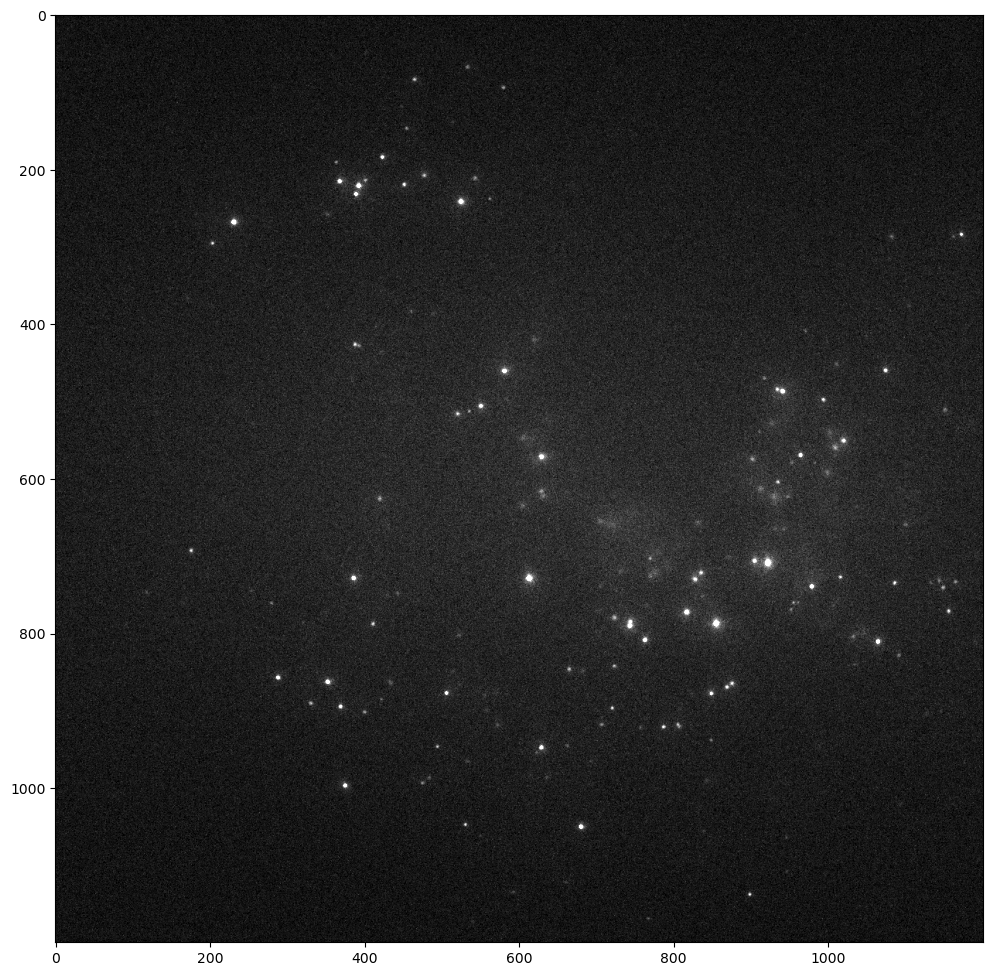

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(image_of_particles, vmin=100, vmax=200, cmap="gray")
plt.tight_layout()
plt.show()

... and extract and plot a crop with a single quantum dot.

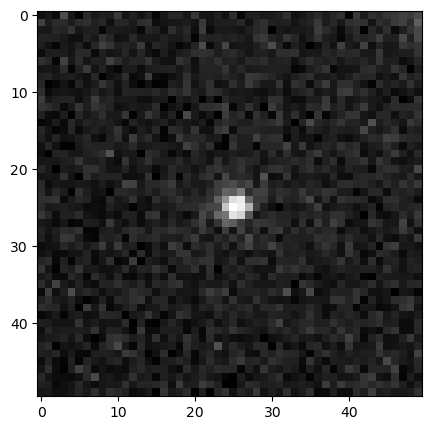

In [5]:
x0, y0, crop_size = 178, 271, 50
crop = image_of_particles.crop((x0, y0, x0 + crop_size, y0 + crop_size))

plt.figure(figsize=(5, 5))
plt.imshow(crop, cmap="gray", vmin=100, vmax=200)
plt.show()

## Simulating Images of Quantum Dots

### Simulating Images of a Single Quantum Dot

Define the simulation pipeline for the image of a single quantum dot ...

In [6]:
import deeptrack as dt
import numpy as np
from numpy.random import poisson

optics = dt.Fluorescence(
    wavelength=600 * dt.units.nm,
    NA=0.9,
    magnification=1,
    resolution=0.11 * dt.units.um,
    output_region=(0, 0, 50, 50),
)
particle = dt.PointParticle(
    position=(25, 25),
    intensity=1.2e4,
    z=0,
)
simulation_pipeline = optics(particle) >> dt.Add(30) >> poisson >> dt.Add(82)

2024-03-26 06:01:42.380739: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


... and compare between experimental and simulated images of quantum dots.

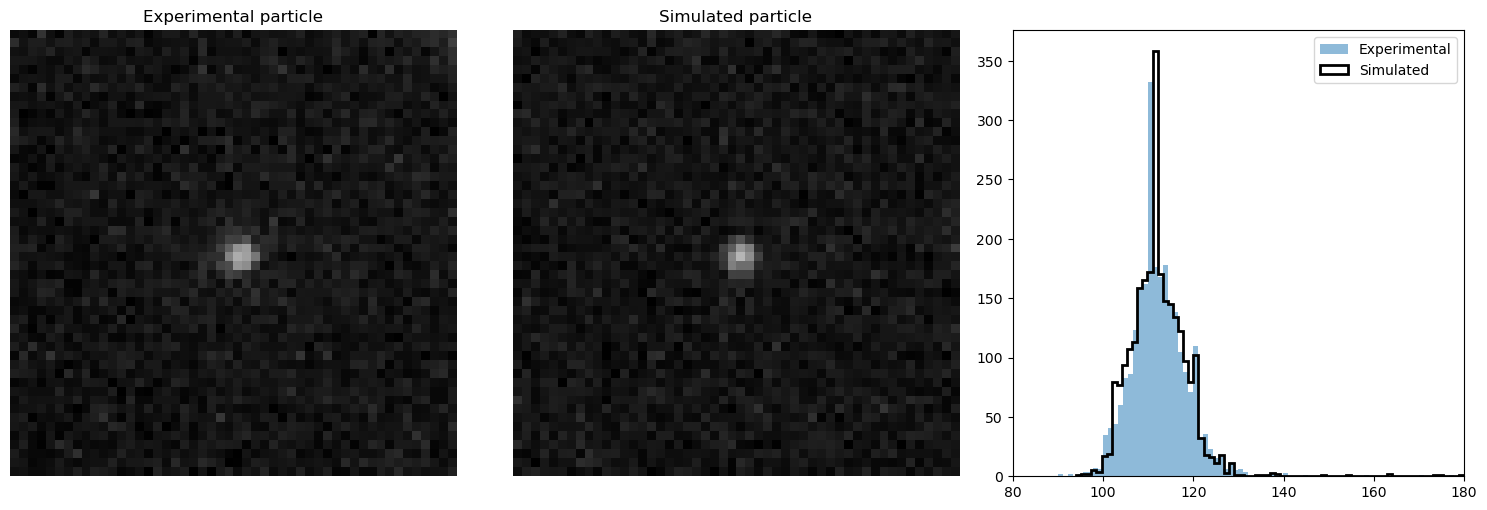

In [7]:
simulation_pipeline.update()
simulated_image = simulation_pipeline()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(crop, cmap="gray", vmin=100, vmax=250)
plt.axis("off")
plt.title("Experimental particle")

plt.subplot(1, 3, 2)
plt.imshow(simulated_image, cmap="gray", vmin=100, vmax=250)
plt.axis("off")
plt.title("Simulated particle")

plt.subplot(1, 3, 3)
plt.hist(np.array(crop).flatten(), bins=100, label="Experimental", alpha=0.5)
plt.hist(np.array(simulated_image).flatten(), bins=100, label="Simulated",
         histtype="step", color="black", linewidth=2)
plt.xlim([80, 180])
plt.legend()

plt.tight_layout()
plt.show()

### Simulating Images with Multiple Quantum Dots

Update the simulation pipeline to create images of multiple quantum dots ...

In [8]:
from numpy.random import poisson, randint, uniform

optics = dt.Fluorescence(
    wavelength=600 * dt.units.nm,
    NA=0.9,
    magnification=1,
    resolution=0.11 * dt.units.um,
    output_region=(0, 0, 128, 128),
)
particle = dt.PointParticle(
    position=lambda: uniform(0, 128, size=2),
    intensity=lambda: uniform(6e3, 3e4),
    z=lambda: uniform(-1.5, 1.5) * dt.units.um,
)
postprocess = (dt.Add(lambda: uniform(20, 40)) >> poisson
               >> dt.Add(lambda: uniform(70, 90)))
normalization = dt.AsType("float") >> dt.Subtract(110) >> dt.Divide(250)
particles = particle ^ (lambda: randint(10, 20))
simulation_pipeline = optics(particles) >> postprocess >> normalization

... define the simulation pipeline for the output mask ...

In [9]:
gt_masks = (
    particles
    >> dt.SampleToMasks(
        lambda: lambda particle: particle > 0,
        output_region=optics.output_region,
        merge_method="or",
    )
    >> dt.AsType("int")
    >> dt.OneHot(num_classes=2)
)

... combine the pipelines for the quantum dot image and the ground truth
mask ...

In [11]:
import torch

image_mask_pipeline = (
    (simulation_pipeline & gt_masks)
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

... and plot the simulated image and corresponding ground truth mask.

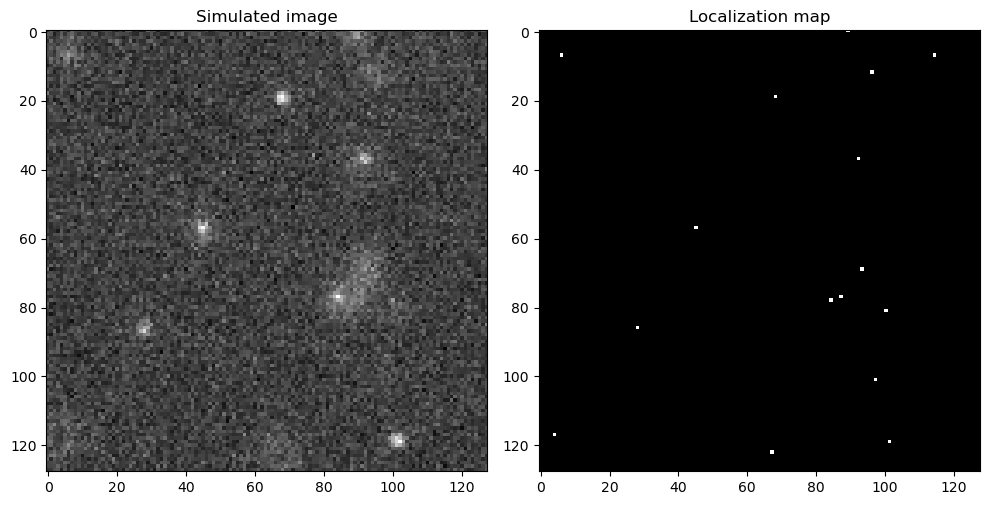

In [12]:
simulated_image, gt_image = image_mask_pipeline()

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(simulated_image.squeeze(), cmap="gray")
plt.title("Simulated image")

plt.subplot(1, 2, 2)
plt.imshow(gt_image[1], cmap="gray")
plt.title("Localization map")

plt.tight_layout()
plt.show()

## Defining and Training the U-Net

Define the U-Net ...

In [13]:
import deeplay as dl

unet = dl.UNet2d(in_channels=1, channels=[32, 64], out_channels=2)

print(unet)

... compile it for the task of regressing the masks from the images ...

In [14]:
from torch.nn import CrossEntropyLoss

unet_regressor = dl.Regressor(
    model=unet,
    loss=CrossEntropyLoss(weight=torch.tensor([1, 10])),
    optimizer=dl.Adam(),
).create()

print(unet_regressor)

... and train it.

In [15]:
from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(image_mask_pipeline, length=320, replace=0.1)
data_loader = DataLoader(train_dataset, batch_size=32)
unet_trainer = dl.Trainer(max_epochs=50, accelerator="auto")
unet_trainer.fit(unet_regressor, data_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO: 
  | Name          | Type             | Params

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


## Evaluating the Trained U-Net

### Visualizing the Predicted Masks Corresponding to a Simulated Image

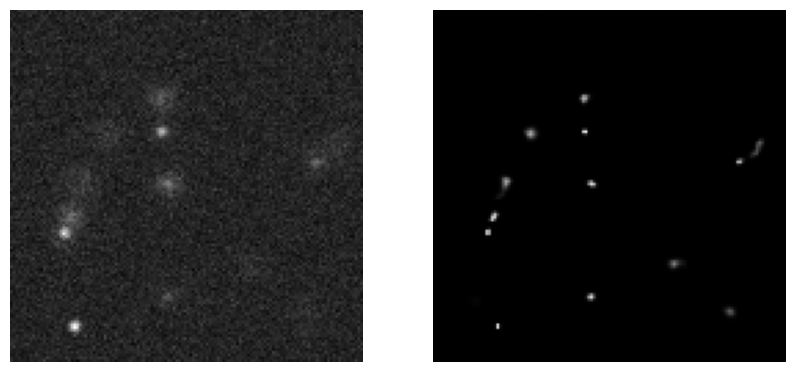

In [17]:
image_mask_pipeline.update()

raw_image, _ = image_mask_pipeline()
raw_image = raw_image.unsqueeze(0)
pred = unet_regressor(raw_image).detach()
pred = torch.nn.functional.softmax(pred, dim=1)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(raw_image.squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred.squeeze()[1], vmin=0, vmax=1.0, cmap="gray")

plt.axis("off")
plt.show()

### Evaluating the Accuracy of the Trained U-Net

Implement a function to convert a binary mask into an array of centroid positions ...

In [18]:
from skimage.measure import label, regionprops

def mask_to_positions(mask):
    """Convert binary mask to centroid array."""
    labels = label(mask)
    props = regionprops(labels)
    return np.array([prop.centroid for prop in props])

... implement a function to match predicted and true positions ...

In [16]:
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment

def match_positions(predicted_positions, true_positions, max_distance=2):
    """Match predicted and true positions."""
    if len(predicted_positions) == 0 or len(true_positions) == 0:
        return [], []
    d_matrix = distance_matrix(predicted_positions, true_positions)
    row_indices, col_indices = linear_sum_assignment(d_matrix)
    too_far = d_matrix[row_indices, col_indices] > max_distance
    return row_indices[~too_far], col_indices[~too_far]

... and calculate and plot the F1-score as a function of the position and
intensity of the quantum dot.

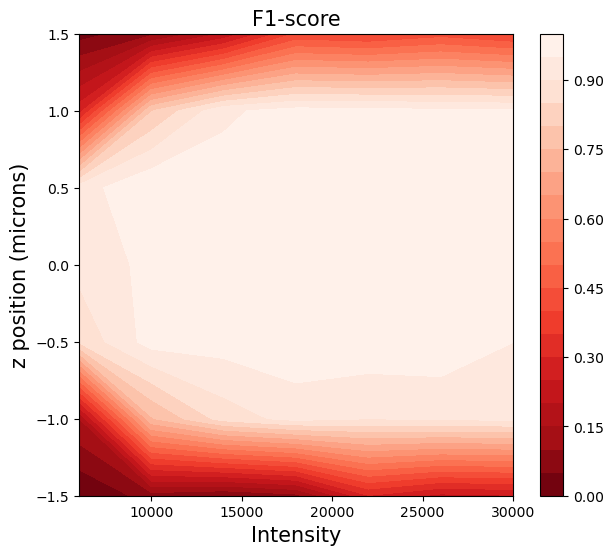

In [21]:
bins, images_per_bin = 7, 5
z_range = np.linspace(-1.5, 1.5, bins) * dt.units.um
intensity_range = np.linspace(6e3, 3e4, bins)

TP, FP, FN = [np.zeros((bins, bins)) for _ in range(3)]
for z_index, z in enumerate(z_range):
    for intensity_index, intensity in enumerate(intensity_range):
        for image_index in range(images_per_bin):
            print(f"Image {image_index} z={z:.2f} I={intensity}", end="\r")
    
            # Generate image
            image_mask_pipeline.update()
            image, gt_mask = image_mask_pipeline(z=z, intensity=intensity)
        
            # Predict mask
            pred_mask = unet_regressor(image.unsqueeze(0)).detach()
            pred_mask = torch.nn.functional.softmax(pred_mask, dim=1)
            
            # Compute metrics
            gt_positions = mask_to_positions(gt_mask[1, ...] > 0.5)
            pred_positions = mask_to_positions(pred_mask[0, 1, ...] > 0.5)
            row_indices, _ = match_positions(pred_positions, gt_positions)
            num_matches = len(row_indices)
            TP[z_index, intensity_index] += num_matches
            FP[z_index, intensity_index] += len(pred_positions) - num_matches
            FN[z_index, intensity_index] += len(gt_positions) - num_matches

F1 = 2 * TP / (2 * TP + FP + FN)

plt.figure(figsize=(7, 6))
plt.contourf(intensity_range, z_range, F1, levels=20, vmin=0, vmax=1, 
             cmap="Reds_r")
plt.colorbar()
plt.title("F1-score", fontsize=15)
plt.xlabel("Intensity", fontsize=15)
plt.ylabel("z position (microns)", fontsize=15)
plt.show()

### Applying the Trained U-Net to Experimental Data

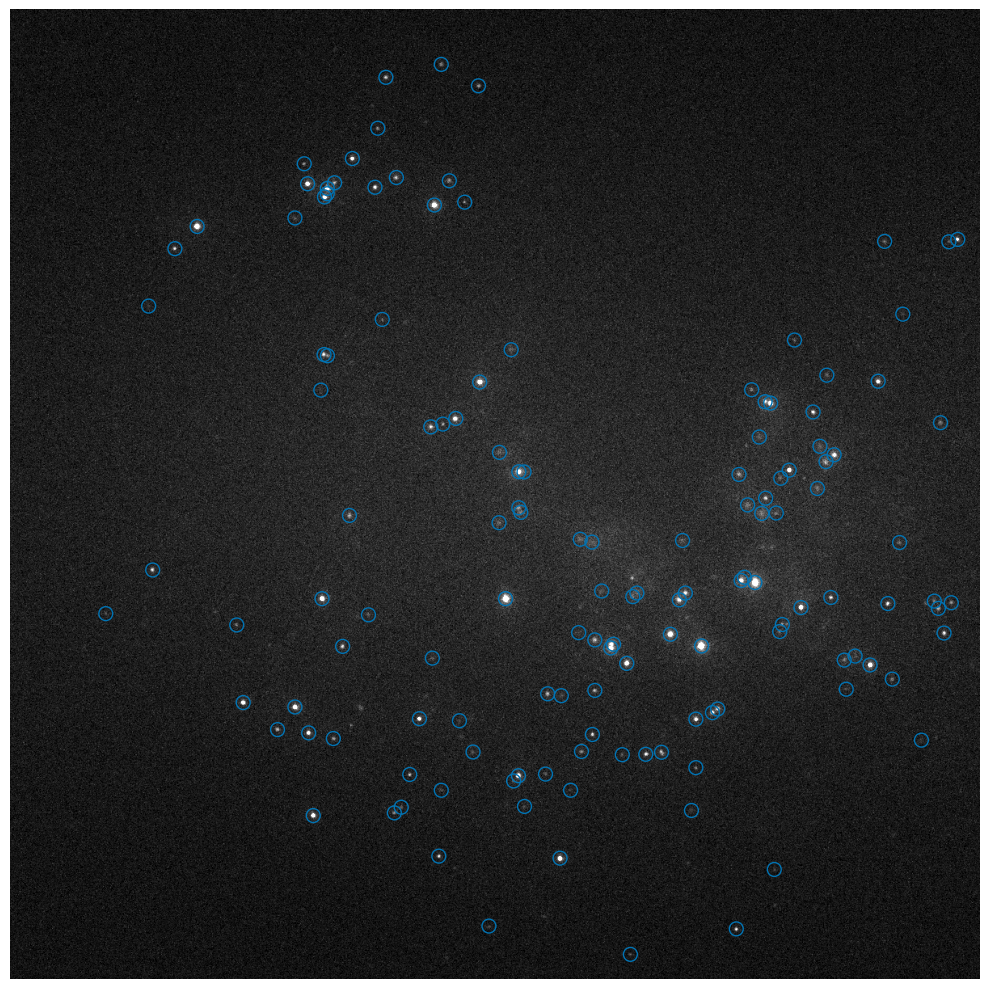

In [20]:
image_of_particles_tensor = torch.from_numpy(
    (np.array(image_of_particles).astype(np.float32) - 110) / 250
).unsqueeze(0)

pred_mask = unet_regressor(image_of_particles_tensor.unsqueeze(0)).detach()
pred_mask = torch.nn.functional.softmax(pred_mask, dim=1)
positions = mask_to_positions(pred_mask[0, 1, ...] > 0.5)

plt.figure(figsize=(10, 10))
plt.imshow(image_of_particles, vmin=100, vmax=200, cmap="gray")
plt.scatter(positions[:, 1], positions[:, 0], s=100, facecolors="none",
            edgecolors=(0.0039, 0.45, 0.70))
plt.axis("off")
plt.tight_layout()
plt.show()